# Model Selection within Student's t Regression

Let us recall that the Student's t distribution is given as
$$
p(y | \mu, \sigma, \nu) = \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)} \frac{1}{\sqrt{\nu\pi\sigma^2}} \left(1 + \frac{(y - \mu)^2}{\nu\sigma^2}\right)^{-\frac{\nu+1}{2}}
$$
where $\mu$ is the mean, $\sigma$ is the scale, and $\nu$ is the degrees of freedom. The gamma function is given as
$$
\Gamma(x) = \int_0^\infty t^{x-1} e^{-t} dt.
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

I will derive the likelihood for Student's t *linear* regression (i.e. linear regression with centred Student's t errors with nonnegative scale $\sigma$ and degrees of freedom $\nu$) for $n$ observations.

<div style="height:20.9cm;">
The linear regression model is given by

$$
y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \ldots + \beta_p x_{ip} + \epsilon_i
$$

where:
- $y_i$ is the response variable for observations $i$;
- $\beta_0$, $\beta_1$, ..., $\beta_p$ are the regression coefficients;
- $x_{i1}$, $x_{i2}$, ..., $x_{ip}$ are the explanatory variables for observation $i$; and
- $\epsilon_i$ is the error of observation $i$.

In matrix notation, this can be expressed as

$$
Y = X \beta + \epsilon
$$

where:
- $Y$ is the vector of responses;
- $X$ is the design matrix;
- $\beta$ is the vector of parameters; and
- $\epsilon$ is the vector of errors.

We have centred Student's t errors with nonnegative scale $\sigma$ and degrees of freedom $\nu$. That is, $\epsilon_i \sim t_{\nu}(\mu=0, \sigma, \nu)$. For observation $i$, we can therefore write

$$
p(\epsilon_i \mid \sigma, \nu) = \frac{ \Gamma \left( \frac {\nu + 1} { 2 } \right) } { \Gamma \left( \frac { \nu } { 2 } \right) } \frac { 1 } { \sqrt { \nu \pi \sigma ^ 2 } } \left( 1 + \frac { \epsilon_i^2 } { \nu \sigma^2} \right) ^ { -\frac {\nu + 1 } { 2 }}.
$$

Assuming the errors are independent, the likelihood function is the product of the individual probability distribution functions:

\begin{align*}
L(\beta, \sigma, \nu \mid Y, X) &= \prod_{i=1}^{n} p\left(\epsilon_i \mid \sigma, \nu\right)\\
&= \prod_{i=1}^{n} p\left(y_i - X_i \beta \mid \sigma, \nu\right).
\end{align*}

This can then be written explicitly as

$$
L(\beta, \sigma, \nu \mid Y, X) = \prod_{i=1}^{n} \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)} \frac{1}{\sqrt{\nu\pi\sigma^2}} \left(1 + \frac{(y_i - X_i \beta)^2}{\nu\sigma^2}\right)^{-\frac{\nu+1}{2}}.
$$

Using the likelihood derived in the previous step, I will derive the log-likelihood and code a function that evaluates this log-likelihood.

<div style="height:7.2cm;">
Take the natural logarithm to obtain the log-likelihood.

\begin{align*}
\mathcal{L}(\beta, \sigma, \nu | Y, X) &= \textnormal{log} \left( L(\beta, \sigma, \nu | Y, X) \right)\\
&= \textnormal{log} \left( \prod_{i=1}^{n} \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)} \frac{1}{\sqrt{\nu\pi\sigma^2}} \left(1 + \frac{(y_i - X_i \beta)^2}{\nu\sigma^2}\right)^{-\frac{\nu+1}{2}} \right)\\
&= \sum_{i=1}^{n} \textnormal{log} \left( \frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)} \frac{1}{\sqrt{\nu\pi\sigma^2}} \left(1 + \frac{(y_i - X_i \beta)^2}{\nu\sigma^2}\right)^{-\frac{\nu+1}{2}} \right)\\
&= \sum_{i=1}^{n} \left[\log\Gamma\left(\frac{\nu+1}{2}\right) - \log\Gamma\left(\frac{\nu}{2}\right) - \frac{1}{2}\log(\nu\pi\sigma^2) - \frac{\nu+1}{2} \log\left(1 + \frac{(y_i - X_i \beta)^2}{\nu\sigma^2}\right)\right]
\end{align*}

In [2]:
def log_likelihood(y, X, beta, sigma, nu):
    residuals = y - X @ beta
    log_likelihood = np.sum(stats.t.logpdf(residuals, scale=sigma, df=nu))
    return log_likelihood

# test points - do not change
print(log_likelihood(np.array([1, 2, 3]), np.array([[1, 2], [3, 4], [5, 6]]), np.array([1, 2]), 1, 1))
print(log_likelihood(np.array([1, 2, 3]), np.array([[1, 2], [3, 4], [5, 6]]), np.array([1, 2]), 1, 5))
print(log_likelihood(np.array([1, 2, 3]), np.array([[1, 2], [3, 4], [5, 6]]), np.array([1, 2]), 2, 10))

-15.957325977606658
-26.827441481365288
-22.611979832718994


I am interested in estimating $\beta$, $\sigma$ and $\nu$, hence will denote the log-likelihood $\mathcal{L}(\beta, \sigma, \nu)$. I will use gradient descent to maximise this log-likelihood w.r.t. $\beta$ and $\sigma$.

I will start by deriving the partial derivatives of $\mathcal{L}$ w.r.t. $\beta$ and $\sigma$.

<div style="height:10.8cm;">
Note that $\beta$ is a vector so we will have to use vector calculus.

\begin{align*}
\frac{\partial \mathcal{L}}{\partial \beta} &= \sum_{i=1}^{n} \left[0 + 0 + 0 - \frac{\nu+1}{2} \frac{1}{1 + \frac{(y_i - X_i \beta)^2}{\nu\sigma^2}} \frac{2}{\nu\sigma^2} (y_i - X_i \beta) (-X_i^T) \right]\\
&= \sum_{i=1}^{n} \left[\frac{\nu+1}{\nu\sigma^2} \frac{y_i - X_i \beta}{1 + \frac{(y_i - X_i \beta)^2}{\nu\sigma^2}}X_i^T\right]\\
&= \frac{\nu+1}{\nu\sigma^2} \sum_{i=1}^{n} \frac{y_i - X_i \beta}{1 + \frac{(y_i - X_i \beta)^2}{\nu\sigma^2}} X_i^T
\end{align*}

Thankfully $\sigma$ is a scalar.

\begin{align*}
\frac{\partial \mathcal{L}}{\partial \sigma} &= \sum_{i=1}^{n} \left[0 + 0 - \frac{1}{2} \frac{1}{\nu\pi\sigma^2} 2\nu\pi\sigma - \frac{\nu+1}{2} \frac{1}{1 + \frac{(y_i - X_i \beta)^2}{\nu\sigma^2}}\left( - \frac{ 2 (y_i - X_i \beta)^2}{\nu\sigma^3} \right)\right]\\
&= \sum_{i=1}^{n} \left[ -\frac{1}{\sigma} + \frac{\nu+1}{\nu\sigma^3} \frac{(y_i - X_i \beta)^2}{ 1 + \frac{(y_i - X_i \beta)^2 }{\nu\sigma^2} }\right]
\end{align*}

I will then code a function that evaluates the partial derivatives of $\mathcal{L}$ w.r.t. $\beta$ and $\sigma$.

In [3]:
def gradient_beta(y, X, beta, nu, sigma):
    # Initialise the gradient to be returned
    gradient = np.zeros_like(beta, dtype=float)
    # Apply the formula derived above, looping over all observations
    n = len(y)
    for i in range(n):
        residual = y[i] - X[i] @ beta
        denominator_term = 1 + residual**2 / (nu * sigma**2)
        gradient += (nu + 1) / (nu * sigma**2) * residual / denominator_term * X[i]
    return gradient

# test points - do not change
print(gradient_beta(np.array([1, 2, 3]), np.array([[1, 2], [3, 4], [5, 6]]), np.array([1, 2]), 1, 1))
print(gradient_beta(np.array([1, 2, 3]), np.array([[1, 2], [3, 4], [5, 6]]), np.array([1, 2]), 5, 1))
print(gradient_beta(np.array([1, 2, 3]), np.array([[1, 2], [3, 4], [5, 6]]), np.array([1, 2]), 10, 2))

def gradient_sigma(y, X, beta, nu, sigma):
    # Initialise the gradient to be returned
    gradient = 0.0
    # Apply the formula derived above, looping over all observations
    n = len(y)
    for i in range(n):
        residual = y[i] - X[i] @ beta
        denominator_term = 1 + residual**2 / (nu * sigma**2)
        gradient += -1/sigma + (nu + 1) / (nu * sigma**3) * residual**2 / denominator_term
    return gradient

# test points - do not change
print(gradient_sigma(np.array([1, 2, 3]), np.array([[1, 2], [3, 4], [5, 6]]), np.array([1, 2]), 1, 1))
print(gradient_sigma(np.array([1, 2, 3]), np.array([[1, 2], [3, 4], [5, 6]]), np.array([1, 2]), 5, 1))
print(gradient_sigma(np.array([1, 2, 3]), np.array([[1, 2], [3, 4], [5, 6]]), np.array([1, 2]), 10, 2))

[-1.83978472 -2.67201713]
[-5.11613031 -7.30480488]
[-6.5029716  -8.75941008]
2.8478104130100723
13.07333763078296
8.321043363416244


I will now code a function that performs gradient descent to maximise the log-likelihood.

In [4]:
def gradient_descent(X, y, nu, learning_rate, max_iter):

    # Initialise the parameters to be maximised
    beta = np.zeros(X.shape[1])
    sigma = 1.0
    # Define convergence criterion
    epsilon = 1e-9
    
    # Create a list to store log-likelihood values
    log_likelihood_values = []
    # Initialise prev_log_likelihood variable with negative infinity
    prev_log_likelihood = float('-inf')

    for iteration in range(max_iter):
        
        current_log_likelihood = log_likelihood(y, X, beta, sigma, nu)
        
        # Check for convergence
        if np.abs(current_log_likelihood - prev_log_likelihood) < epsilon:
            break
            
        # Calculate the gradients
        grad_beta = gradient_beta(y, X, beta, nu, sigma)
        grad_sigma = gradient_sigma(y, X, beta, nu, sigma)
        
        # Update the parameter estimates
        beta += learning_rate * grad_beta
        sigma += learning_rate * grad_sigma

        log_likelihood_values.append(current_log_likelihood)
        prev_log_likelihood = current_log_likelihood

    return beta, sigma

I will load $\texttt{data.csv}$ and fit the Student's t regression model to the data using my gradient descent function. To compare, I will use the `statsmodels` package to fit a Student's t regression model to the data. To perform the test, specify $\nu = 10$.

In [5]:
import statsmodels.api as sm
from statsmodels.miscmodels.tmodel import TLinearModel
import pandas as pd

nu = 10

In [6]:
# Load data
data = pd.read_csv('data/data.csv')

# Extract features and target variable
X = data[['x1', 'x2']].values
y = data['y'].values

# Add a constant to the model (the intercept term)
X_with_intercept = sm.add_constant(X)

# Apply gradient descent function
beta_gradient_descent, sigma_gradient_descent = gradient_descent(X_with_intercept, y, nu, learning_rate=0.0001, max_iter=1000)
print('Gradient Descent - Optimised Beta:', beta_gradient_descent)
print('Gradient Descent - Optimised Sigma:', sigma_gradient_descent)

Gradient Descent - Optimised Beta: [ 0.50101384 -0.46721985  1.23921152]
Gradient Descent - Optimised Sigma: 0.6556943651838807


In [7]:
# Fit using the statsmodels package
t_model = TLinearModel(y, X_with_intercept, df=nu, fix_df=nu)
t_model_fit = t_model.fit(disp=False)
print(t_model_fit.summary())

running Tmodel initialize
                             TLinearModel Results                             
Dep. Variable:                      y   Log-Likelihood:                -1196.9
Model:                   TLinearModel   AIC:                             2402.
Method:            Maximum Likelihood   BIC:                             2421.
Date:                Thu, 03 Oct 2024                                         
Time:                        16:01:06                                         
No. Observations:                1000                                         
Df Residuals:                     996                                         
Df Model:                           2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5011      0.022     22.475      0.000       0.457       0.545
x1            -0.4671     

These values very nearly match. The slight differences are due to different optimisation algorithms giving very slightly different optimal parameters.

I will implement the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC) for the model I have fitted and show that these match `TLinearModel` output for specific $\nu$ given above.

In [8]:
def calculate_aic(log_likelihood, p):
    return -2 * log_likelihood + 2 * p

def calculate_bic(log_likelihood, p, n):
    return -2 * log_likelihood + p * np.log(n)

log_likelihood_gradient_descent = log_likelihood(y, X_with_intercept, beta_gradient_descent, sigma_gradient_descent, nu)
# Get the number of observations and the number of parameters
n = len(y)
p = len(beta_gradient_descent) + 1

# Apply calculate_aic and calculate_bic to calculate AIC and BIC values for the model I have fitted
aic_gradient_descent = calculate_aic(log_likelihood_gradient_descent, p)
bic_gradient_descent = calculate_bic(log_likelihood_gradient_descent, p, n)

# Get AIC and BIC values from TLinearModel output
aic_statsmodels = t_model_fit.aic
bic_statsmodels = t_model_fit.bic

# Print AIC and BIC values to 2 decimal places
print(f'TLinearModel output - AIC:    {aic_statsmodels:.2f}')
print(f'Gradient Descent - AIC:       {aic_gradient_descent:.2f}')
print(f'TLinearModel output - BIC:    {bic_statsmodels:.2f}')
print(f'Gradient Descent - BIC:       {bic_gradient_descent:.2f}')

TLinearModel output - AIC:    2401.74
Gradient Descent - AIC:       2401.74
TLinearModel output - BIC:    2421.37
Gradient Descent - BIC:       2421.37


These values (to 2 decimal places) do indeed match. However, if we display more decimal places, there will be slight differences. This is due to different optimisation algorithms giving very slightly different optimised parameters.

In [9]:
print(f'TLinearModel output - AIC:    {aic_statsmodels:.5f}')
print(f'Gradient Descent - AIC:       {aic_gradient_descent:.5f}')
print(f'TLinearModel output - BIC:    {bic_statsmodels:.5f}')
print(f'Gradient Descent - BIC:       {bic_gradient_descent:.5f}')

TLinearModel output - AIC:    2401.74345
Gradient Descent - AIC:       2401.74332
TLinearModel output - BIC:    2421.37447
Gradient Descent - BIC:       2421.37434


I will specify a range of values (given below) for the $\nu$ parameter and plot AIC and BIC w.r.t. $\nu$.

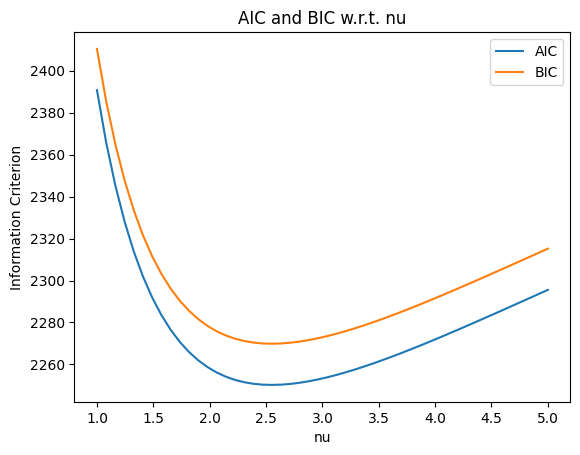

In [10]:
import os
import sys

nu_range = np.linspace(1, 5, 50)

# Initialise lists to store AIC and BIC values
aic_values = []
bic_values = []

# Calculate AIC and BIC for each nu in the range
for nu in nu_range:
    
    # Temporarily redirect stdout to suppress messages
    original_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')

    # Fit using the statsmodels package for the current nu
    t_model_nu = TLinearModel(y, X_with_intercept, df=nu, fix_df=nu)
    t_model_fit_nu = t_model_nu.fit(disp=False)

    # Restore stdout
    sys.stdout = original_stdout

    # Get AIC and BIC from TLinearModel output
    aic_values.append(t_model_fit_nu.aic)
    bic_values.append(t_model_fit_nu.bic)

# Plot AIC and BIC w.r.t. nu
plt.figure()
plt.plot(nu_range, aic_values, label='AIC')
plt.plot(nu_range, bic_values, label='BIC')
plt.ylabel('Information Criterion')
plt.xlabel('nu')
plt.title('AIC and BIC w.r.t. nu')
plt.legend()
plt.show()

In [11]:
# Find the index of the minimum AIC and BIC values
min_aic_index = np.argmin(aic_values)
min_bic_index = np.argmin(bic_values)

# Find the corresponding nu values for the minimum AIC and BIC values
best_nu_aic = nu_range[min_aic_index]
best_nu_bic = nu_range[min_bic_index]

# Print the best nu values to 2 decimal places
print(f'Best nu value for AIC: {best_nu_aic:.2f}')
print(f'Best nu value for BIC: {best_nu_bic:.2f}')

Best nu value for AIC: 2.55
Best nu value for BIC: 2.55


I will: perform cross-validation to choose the best $\nu$ for the model using the negative log-likelihood function as the loss function; plot CV loss estimates w.r.t. $\nu$; choose the best $\nu$ for this model.

In [12]:
from sklearn.model_selection import KFold

# Initialise list to store negative log-likelihood values for each nu
negative_log_likelihood_values = []

# Perform k-fold cross-validation for each nu in the range with k=10
kfold = KFold(n_splits=10)

for nu in nu_range:
    
    log_likelihood_per_nu = 0.0

    for train_index, test_index in kfold.split(X_with_intercept):
        
        X_train, X_test = X_with_intercept[train_index], X_with_intercept[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit for the current nu on the training set
        beta_est, sigma_est = gradient_descent(X_train, y_train, nu, learning_rate=0.0001, max_iter=1000)
        
        # Calculate the log-likelihood on the test set
        log_likelihood_per_nu += log_likelihood(y_test, X_test, beta_est, sigma_est, nu)
    
    # Store the negative log-likelihood
    negative_log_likelihood_values.append(-log_likelihood_per_nu)

# Find the index of the minimum negative log-likelihood
min_nll_index = np.argmin(negative_log_likelihood_values)

# Find the corresponding nu value for the minimum negative log-likelihood
best_nu_nll = nu_range[min_nll_index]

# Print the best nu values to 2 decimal places
print(f'Best nu value from 10-Fold Cross-Validation: {best_nu_nll:.2f}')

Best nu value from 10-Fold Cross-Validation: 2.55


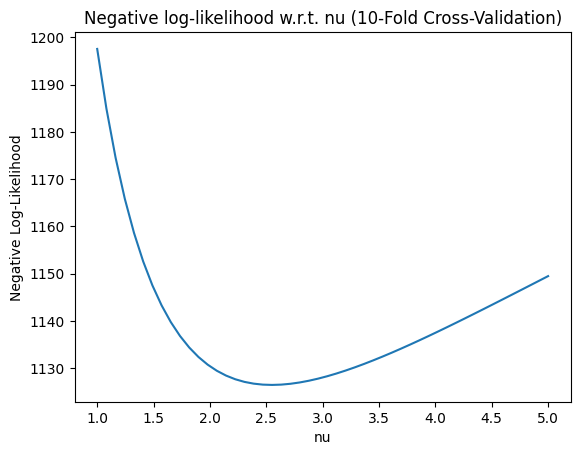

In [13]:
# Plot negative log-likelihood w.r.t. nu
plt.figure()
plt.plot(nu_range, negative_log_likelihood_values)
plt.ylabel('Negative Log-Likelihood')
plt.xlabel('nu')
plt.title('Negative log-likelihood w.r.t. nu (10-Fold Cross-Validation)')
plt.show()

This agrees with AIC/BIC results.